In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File_path

file_path = '/content/Alphabet_growth.csv'

In [ ]:
# Load the data
try:
    df = pd.read_csv(file_path, sep=';', header=2)

    df = df.dropna(axis=1, how='all')

    print("Data loaded successfully!")
    print("Columns found:", df.columns.tolist())
    display(df.head())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")

Data loaded successfully!
Columns found: ['Segment', 'Baseline_Revenue', 'Growth_2026', 'Growth_2027', 'Growth_2028']


,Segment,Baseline_Revenue,Growth_2026,Growth_2027,Growth_2028
0,Ads,267.28,0.08,0.06,0.05
1,Cloud,60.60,0.28,0.24,0.20
2,Other,51.60,0.17,0.18,0.19


In [ ]:
# 1. SETUP & CLEANUP

years = [2026, 2027, 2028]
projection_cols = []

# Strip hidden spaces from column names
df.columns = df.columns.str.strip()

# Smart Column Detection
if 'Baseline_Revenue' in df.columns:
    # First time running: Rename it
    df = df.rename(columns={'Baseline_Revenue': 'Rev_2025'})
    current_col = 'Rev_2025'
elif 'Rev_2025' in df.columns:
    # Second time running: It's already renamed, just use it
    current_col = 'Rev_2025'
else:
    # Critical failure check
    print(" ERROR: Could not find 'Baseline_Revenue' OR 'Rev_2025'.")
    print("Your columns are:", df.columns.tolist())
    # We raise an error deliberately to stop execution here
    raise KeyError("Missing Start Column")

# Initialize summary list
summary_cols = ['Segment', 'Rev_2025']

# 2. RUN THE LOOPS
for year in years:
    rate_col = f'Growth_{year}'
    new_rev_col = f'Rev_{year}'
    share_col = f'Share_{year}'

    if rate_col not in df.columns:
        print(f" Error: Column '{rate_col}' missing.")
        break

    # Calculation
    df[new_rev_col] = df[current_col] * (1 + df[rate_col])

    # Share Calculation
    total_rev_year = df[new_rev_col].sum()
    df[share_col] = (df[new_rev_col] / total_rev_year) * 100

    # Update trackers
    current_col = new_rev_col
    projection_cols.append(new_rev_col)
    summary_cols.append(new_rev_col)
    summary_cols.append(share_col)

# 3. RESULTS
print(f"\n--- FULL FORECAST SUMMARY ({years[0]}-{years[-1]}) ---")
display(df[summary_cols].round(2))


--- FULL FORECAST SUMMARY (2026-2028) ---


,Segment,Rev_2025,Rev_2026,Share_2026,Rev_2027,Share_2027,Rev_2028,Share_2028
0,Ads,267.28,288.66,67.67,305.98,64.63,321.28,61.61
1,Cloud,60.60,77.57,18.18,96.18,20.32,115.42,22.13
2,Other,51.60,60.37,14.15,71.24,15.05,84.77,16.26


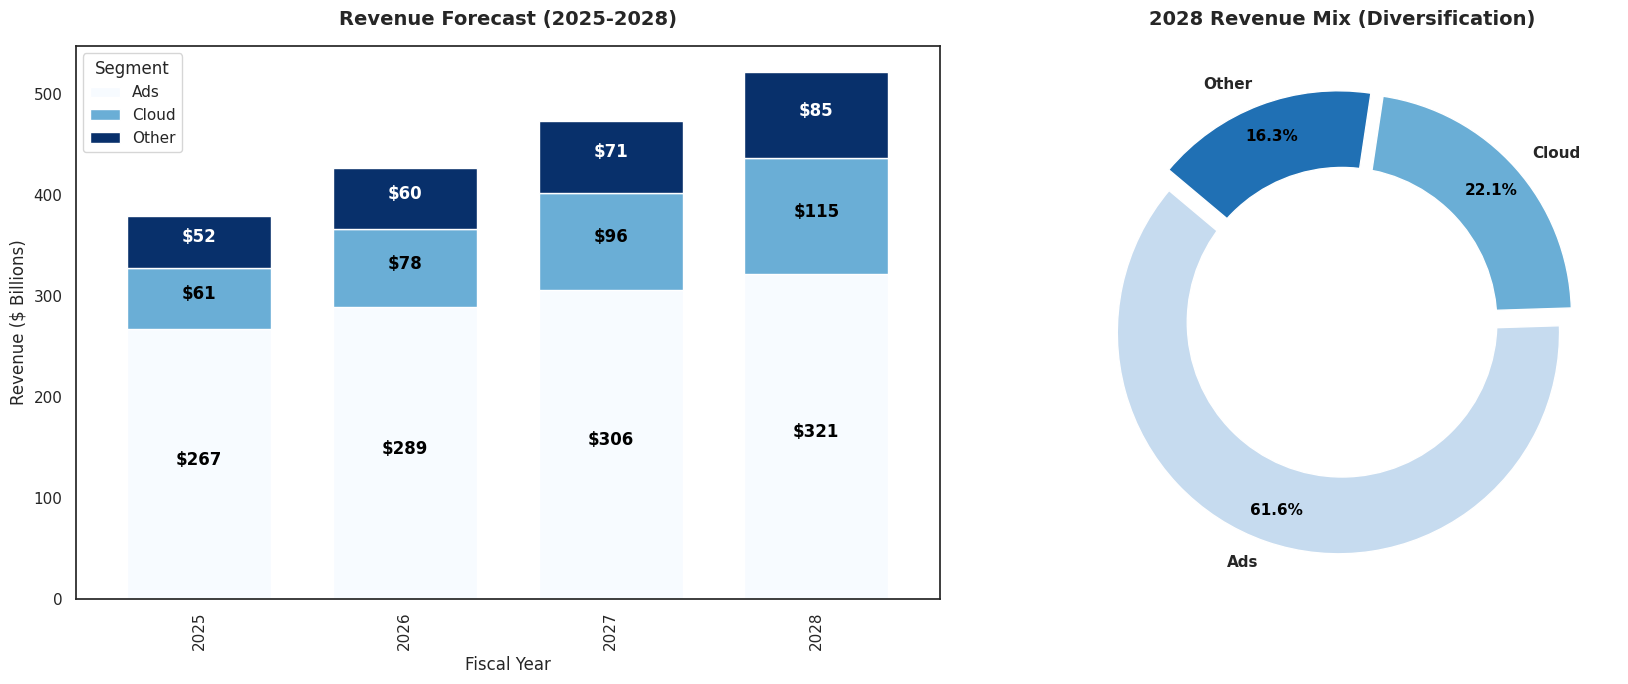

In [ ]:
#  PREPARE DATA FOR BAR CHART

df_viz = df.melt(
    id_vars=['Segment'],
    value_vars=['Rev_2025'] + projection_cols,
    var_name='Year',
    value_name='Revenue'
)
df_viz['Year'] = df_viz['Year'].str.replace('Rev_', '').astype(int)
pivot_df = df_viz.pivot(index='Year', columns='Segment', values='Revenue')

# 2. SETUP DASHBOARD (1 Row, 2 Columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_theme(style="white")

# --- CHART A: STACKED BAR (Revenue Growth) ---

pivot_df.plot(kind='bar', stacked=True, ax=axes[0], colormap='Blues', edgecolor='white', width=0.7)

axes[0].set_title('Revenue Forecast (2025-2028)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Revenue ($ Billions)', fontsize=12)
axes[0].set_xlabel('Fiscal Year', fontsize=12)
axes[0].legend(title='Segment', loc='upper left')

# Add labels to bars

for container in axes[0].containers:
    segment = container.get_label()
    text_color = "white" if segment.lower() == "other" else "black"
    axes[0].bar_label(
        container,
        label_type='center',
        fmt='$%.0f',
        color=text_color,
        fontweight='bold',
        padding=3
    )

# --- CHART B: PIE CHART (2028 Diversification) ---
# Data specifically for 2028
labels = df['Segment']
sizes = df['Rev_2028']

# Generate a list of blue colors to match the bar chart
colors = sns.color_palette('Blues', n_colors=len(labels))

# Create the pie chart on the second axis (axes[1])
wedges, texts, autotexts = axes[1].pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', # Show percentages
    startangle=140,
    colors=colors,
    pctdistance=0.85,  # Push % labels towards the edge
    explode=[0.05]*len(labels) # Slight separation for style
)

# Styling the Pie Text
plt.setp(texts, fontweight='bold', fontsize=11)
plt.setp(autotexts, size=11, weight="bold", color="black")

# Add a "Donut" hole
centre_circle = plt.Circle((0,0),0.70,fc='white')
axes[1].add_artist(centre_circle)

axes[1].set_title('2028 Revenue Mix (Diversification)', fontsize=14, fontweight='bold', pad=15)

# Final Layout Adjustments
plt.tight_layout()
plt.show()